In [1]:
import pandas as pd
import ast
import numpy as np
import os
import glob
import subprocess
import re
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 19})

########################
# Reading and parsing output from benchmarking trials

def read_benchmark_csv(dpath='',filename='latest',delimiter='\t'):
    
    _p = "" 
    if filename == 'latest':
        _p = latest_benchmark_csv(dpath=dpath)
    elif dpath == '': 
        _p = os.path.abspath(filename)
    else:
        _p = os.path.join(dpath,filename)
        
    if not os.path.isfile(_p):
        print("ERROR: Specified path ({_p}) does not lead to a file.")
        exit()
    else:
        print(f"\tFound {_p}...")
        print(f"\tLoading {_p} to a Pandas DataFrame...")
        _df = pd.read_csv(_p, delimiter=delimiter)
        _df = _df[['Item','Action','Type','Source','Target','Trials']]
        print(f"\tCalcuating row stats in DataFrame ...")
        _df['Trials'] = _df['Trials'].apply(lambda x: ast.literal_eval(x))
        _df['Mean'] = _df['Trials'].apply(lambda x: np.mean(x))
        _df['StdDev'] = _df['Trials'].apply(lambda x: np.std(x))
        print(f"\t... done.")
        return _df

def latest_benchmark_csv(dpath=''):
    _d = os.path.abspath(dpath)
    if not os.path.isdir(_d):
        print("ERROR: `dpath` must point to a directory.")
        return None
    _l = glob.glob('*')
    _r = []
    for _f in _l:
        if "results" in _f:
            _r.append(_f)
    _r.sort()
    return _r[-1]

def du(path):
    """
    disk usage in human readable format (e.g. '2,1GB')
    copied from: https://stackoverflow.com/a/25574638 
    """
    return subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8').split()

def split_units(value):
    units = ""
    number = 0
    while value:
        try:
            number = float(value)
            break
        except ValueError:
            units = value[-1:] + units
            value = value[:-1]
    return number, units.strip()    

def zipname_from_folder(path,tag=""):
    return os.path.abspath(path.rstrip('/') + tag + ".zip")

def folder_from_zipname(path,tag=""):
    _p0 = os.path.splitext(path)
    return os.path.abspath(_p0[0] + tag)

def clean_up_folder_names(df):
    """ 
    bench keys are set by zip filename, so need to convert using Type/ZorF column
    """
    for _row in range(len(df)):
        if df.at[_row,'Type'] == 'F':
            df.at[_row,'Item'] = folder_from_zipname(df.at[_row,'Item'])
            
def add_disk_usage_and_item_count(df):
    df['Size'] = float()
    df['Size-Unit'] = str()
    df['Files'] = int()
    df['Folders'] = int()
    _d = {}
    for _item in df['Item'].unique():
        _d[_item,'Size'] = split_units(' '.join(du(_item)))
        _d[_item,'Count'] = count_files_in_item(_item)
        
    for _row in range(len(df)):
        _s,_u = _d[df.at[_row,'Item'],'Size']
        if _u == 'G':
            _s = 1000*_s
            _u = 'M'
        elif _u != 'M':
            print(f"WARNING: Unidentified units may result in incorrect analysis of filesize!")
            print(f"         {_row}\t{df.at[_row,'Item']}\t{_s} {_u}")
        _nfile, _nfold = _d[df.at[_row,'Item'],'Count']
        df.at[_row,'Size'] = _s
        df.at[_row,'Size-Unit'] = _u
        df.at[_row,'Files'] = _nfile
        df.at[_row,'Folders'] = _nfold

def count_files_in_item(path):
    """
    https://codezup.com/count-files-directories-recursively-python/
    """
    noOfDir=0
    noOfFiles=0
    if os.path.isdir(path):
        noOfDir+=1
    elif os.path.isfile(path):
        noOfFiles+=1
        
    for base, dirs, files in os.walk(path):
        print('Looking in : ',base)
        for directories in dirs:
            noOfDir += 1
        for Files in files:
            noOfFiles += 1
    return noOfFiles, noOfDir
        
def remove_root_path_from_items(df):
    for _row in range(len(df)):
        df.at[_row,'Item'] = os.path.split(df.at[_row,'Item'])[-1]

def load_and_cleanup(filename='latest'):
    df = read_benchmark_csv(filename=filename)
    clean_up_folder_names(df)
    add_disk_usage_and_item_count(df)
    remove_root_path_from_items(df)
    return df

########################
# Plots, fits, and stats

def f_linear(x, a, b):
    return a*x + b

def f_quadratic(x, a, b, c):
    return a*x**2 + b*x + c 

def f_power(x, a, b, c):
    return a*x**b + c 

def mean_and_error(popt, pcov, dim=2):
    if dim == 2:
        a, b = popt
        a_err, b_err = np.sqrt(np.diag(pcov))
        return a, a_err, b, b_err
    elif dim == 3:
        a, b, c = popt
        a_err, b_err, c_err = np.sqrt(np.diag(pcov))
        return a, a_err, b, b_err, c, c_err
    else:
        print("ERROR: Invalid `dim` - must be 2 or 3.")
        return None

def fit_and_plot_benchmarks(xdat, ydat, title=None, 
                            xlabel='Time', ylabel='Size(MB)',
                            fit_param_labels=['MBPS','S0'],
                            fit_type='Linear'):
    fig = plt.figure()
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


    ax.set_title(title)
    ax.plot(xdat,ydat,'*', label='Benchmarks')
    ax.set_xlabel(f'{xlabel}')
    ax.set_ylabel(f'{ylabel}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if fit_type == 'Linear':
        popt, pcov = curve_fit(f_linear, xdat, ydat)
        a, a_err, b, b_err = mean_and_error(popt, pcov, dim=2)
        _xmin, _xmax = 0.9*min(xdat), 1.1*max(xdat)
        _x = np.arange(_xmin,_xmax,step=(_xmax-_xmin)/1e5)
        ax.plot(_x, f_linear(_x, *popt), 'r-', 
                label=f"Fit ({fit_param_labels[0]}={a:.1f}±{a_err:.1f}, {fit_param_labels[1]}={b:.1f}±{b_err:.1f})",
                lw=3)
    if fit_type == 'Quadratic':
        popt, pcov = curve_fit(f_quadratic, xdat, ydat)
        a, a_err, b, b_err, c, c_err = mean_and_error(popt, pcov, dim=3)
        ax.plot(xdat, f_quadratic(xdat, *popt), 'r-', 
                label=f"Fit (a={a:.1f}±{a_err:.1f},\n  b={b:.1f}±{b_err:.1f},\n b={c:.1f}±{c_err:.1f})",
                lw=3)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show() 

## Load latest dataset and cleanup for analysis

In [2]:
df = load_and_cleanup(filename='latest')

	Found results_20220218-145947.csv...
	Loading results_20220218-145947.csv to a Pandas DataFrame...
	Calcuating row stats in DataFrame ...
	... done.
Looking in :  Z:\data-lake\TEST\MRI-Coronal
Looking in :  Z:\data-lake\TEST\MRI-Coronal\MRI
Looking in :  Z:\data-lake\TEST\MRI-Coronal\MRI\Coronal
Looking in :  Z:\data-lake\TEST\Ultrasound-Training_scans-20200814164602057
Looking in :  Z:\data-lake\TEST\Ultrasound-Training_scans-20200814164602057\Ultrasound
Looking in :  Z:\data-lake\TEST\Ultrasound-Training_scans-20200814164602057\Ultrasound\Training scans
Looking in :  Z:\data-lake\TEST\Ultrasound-Training_scans-20200814164602057\Ultrasound\Training scans\20200814164602057
Looking in :  Z:\data-lake\TEST\optical-images_SME20210125143045
Looking in :  Z:\data-lake\TEST\optical-images_SME20210125143045\optical
Looking in :  Z:\data-lake\TEST\optical-images_SME20210125143045\optical\optical_images
Looking in :  Z:\data-lake\TEST\optical-images_SME20210125143045\optical\optical_images\SME

## Sort the results, longest to shortest
Here is a first look at the dataset.

In [3]:
df = df.sort_values('Mean',ascending=False).reset_index(drop=True)
df

,Item,Action,Type,Source,Target,Trials,Mean,StdDev,Size,Size-Unit,Files,Folders
0,90minDynamicDataSet_Cu64,Copy,F,Local,Mount,"[129.59194898605347, 132.30008006095886, 128.0...",129.975282,1.513034,171.0,M,5990,3
1,90minDynamicDataSet_Cu64,Compress,F,Mount,Mount,"[106.6390130519867, 97.09376335144043, 100.961...",100.555836,3.818210,171.0,M,5990,3
2,90minDynamicDataSet_Cu64.zip,Extract,Z,Mount,Mount,"[95.78374481201172, 90.84006762504578, 89.4196...",98.196887,10.404382,99.0,M,1,0
3,90minDynamicDataSet_Cu64,Delete,F,Mount,Mount,"[62.99091148376465, 63.56330323219299, 63.3512...",63.501068,0.922007,171.0,M,5990,3
4,90minDynamicDataSet_Cu64,Copy,F,Mount,Local,"[58.97229743003845, 60.045337438583374, 60.104...",59.756689,0.458655,171.0,M,5990,3
...,...,...,...,...,...,...,...,...,...,...,...,...
115,MRI-Axial,Delete,F,Local,Local,"[0.0, 0.015627622604370117, 0.0, 0.0, 0.015626...",0.003907,0.006767,4.8,M,1,3
116,optical-images_SME20210125143045.zip,Delete,Z,Local,Local,"[0.0, 0.015629053115844727, 0.0, 0.0, 0.0, 0.0...",0.001954,0.005169,1.7,M,1,0
117,optical-images_SME20210125143447.zip,Delete,Z,Local,Local,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.015628337860107422...",0.001954,0.005169,5.3,M,1,0
118,optical-images_SME20210125143447,Delete,F,Local,Local,"[0.0, 0.0, 0.015627145767211914, 0.0, 0.0, 0.0...",0.001953,0.005168,7.7,M,7,4


## First, a summary of the sample data

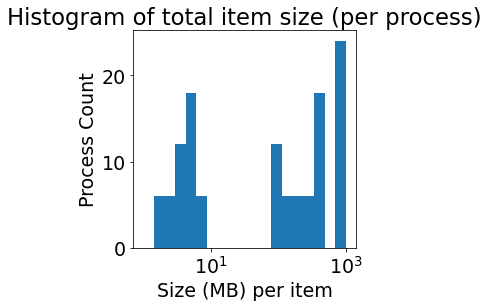

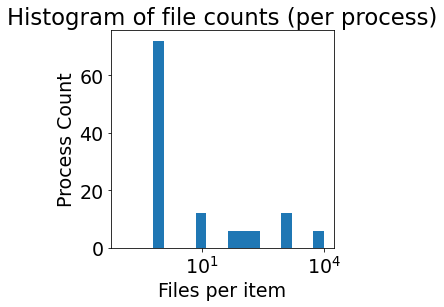

In [4]:
import math

_counts = df['Size'] 
om_max = math.ceil(math.log(max(_counts), 10))
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.set_title('Histogram of total item size (per process)')
ax.hist(_counts, 
        bins=np.logspace(np.log10(1),np.log10(10**om_max), 20))
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("Size (MB) per item")
ax.set_ylabel("Process Count")
plt.show()

_counts = df['Files'] 
om_max = math.ceil(math.log(max(_counts), 10))
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.set_title('Histogram of file counts (per process)')
ax.set_xlabel("Files per item")
ax.set_ylabel("Process Count")
ax.hist(_counts, 
        bins=np.logspace(np.log10(1e-1),np.log10(10**om_max), 20))
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

## Copy-action, fits to estimate MBps and Fps

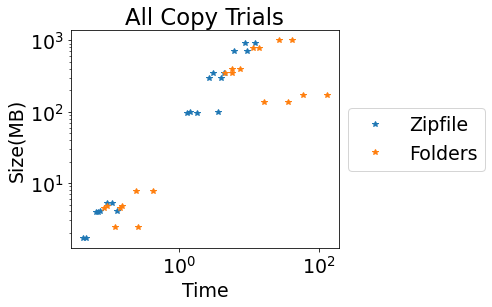

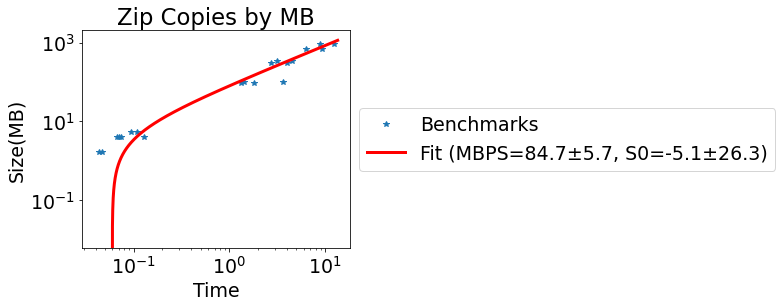

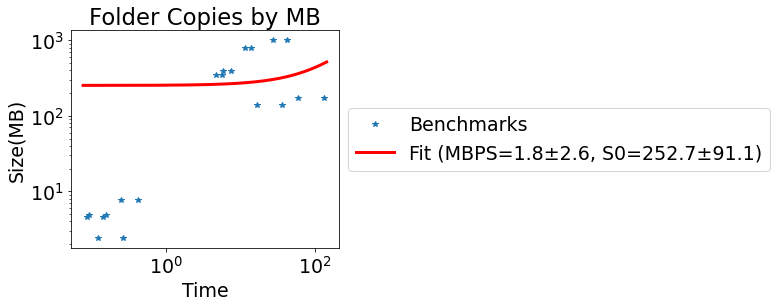

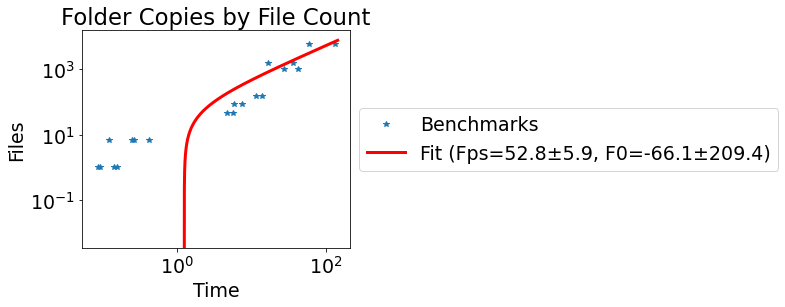

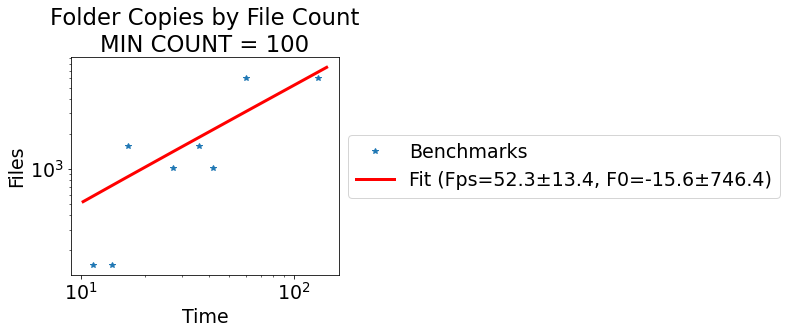

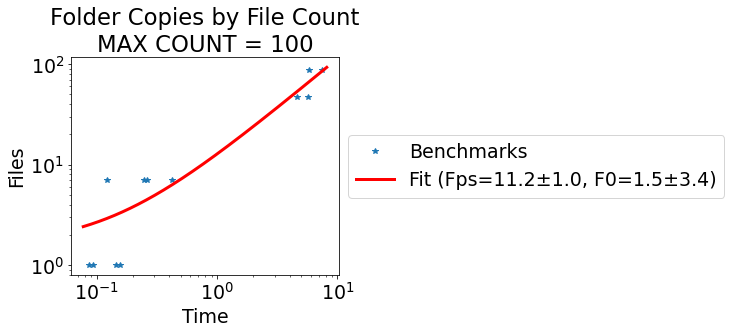

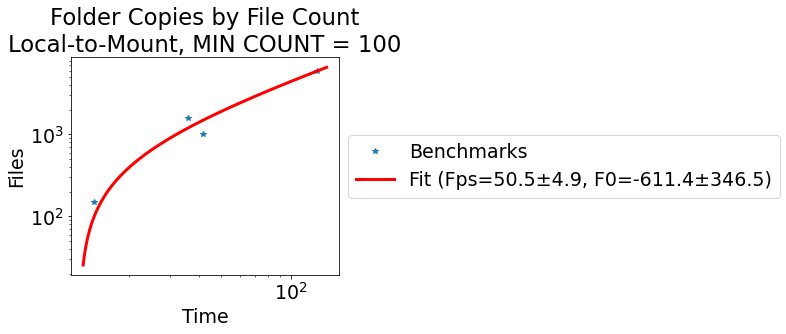

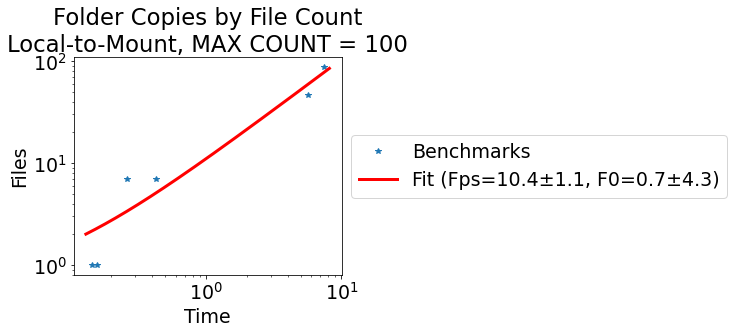

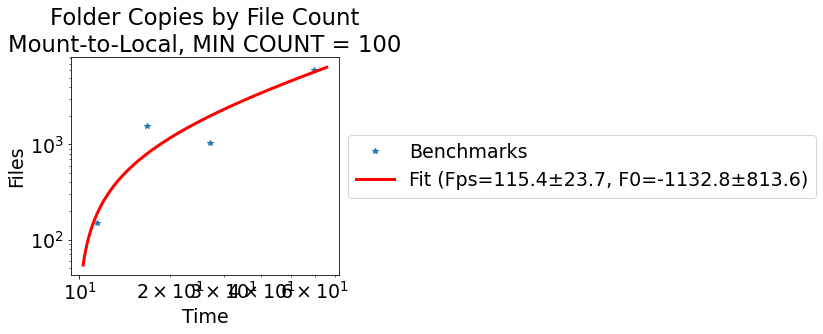

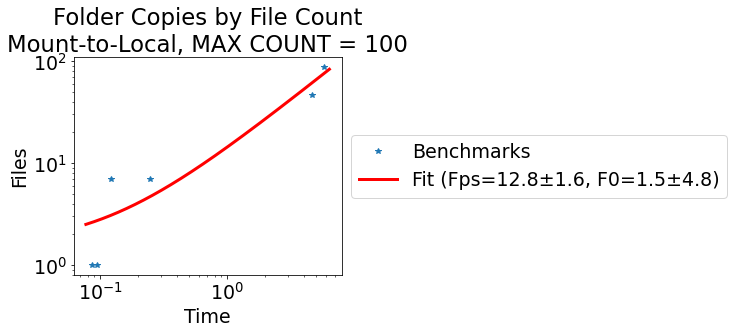

In [8]:
copy_Z = df[(df['Action']=='Copy') & (df['Type']=='Z')].reset_index(drop=True)
copy_F = df[(df['Action']=='Copy') & (df['Type']=='F')].reset_index(drop=True)
copy_Z_M2L = df[(df['Action']=='Copy') & (df['Type']=='Z') & 
                (df['Source']=='Mount') & (df['Target']=='Local')].reset_index(drop=True)
copy_Z_L2M = df[(df['Action']=='Copy') & (df['Type']=='Z')& 
                (df['Source']=='Local') & (df['Target']=='Mount')].reset_index(drop=True)
copy_F_M2L = df[(df['Action']=='Copy') & (df['Type']=='F')& 
                (df['Source']=='Mount') & (df['Target']=='Local')].reset_index(drop=True)
copy_F_L2M = df[(df['Action']=='Copy') & (df['Type']=='F')& 
                (df['Source']=='Local') & (df['Target']=='Mount')].reset_index(drop=True)

fig = plt.figure()
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('All Copy Trials')
ax.plot(copy_Z['Mean'],copy_Z['Size'],'*', label='Zipfile')
ax.plot(copy_F['Mean'],copy_F['Size'],'*', label='Folders')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Size(MB)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fit_and_plot_benchmarks(copy_Z['Mean'], copy_Z['Size'], title='Zip Copies by MB')
fit_and_plot_benchmarks(copy_F['Mean'], copy_F['Size'], title='Folder Copies by MB')
fit_and_plot_benchmarks(copy_F['Mean'], copy_F['Files'], title='Folder Copies by File Count',
                        ylabel='Files', fit_param_labels=['Fps','F0'])
min_files = 100
copy_F_thresh = copy_F[copy_F['Files'] >= min_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nMIN COUNT = {min_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])
max_files = 100
copy_F_thresh = copy_F[copy_F['Files'] <= max_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nMAX COUNT = {max_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])

min_files = 100
copy_F_thresh = copy_F_L2M[copy_F_L2M['Files'] >= min_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nLocal-to-Mount, MIN COUNT = {min_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])
max_files = 100
copy_F_thresh = copy_F_L2M[copy_F_L2M['Files'] <= max_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nLocal-to-Mount, MAX COUNT = {max_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])

min_files = 100
copy_F_thresh = copy_F_M2L[copy_F_M2L['Files'] >= min_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nMount-to-Local, MIN COUNT = {min_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])
max_files = 100
copy_F_thresh = copy_F_M2L[copy_F_M2L['Files'] <= max_files]
fit_and_plot_benchmarks(copy_F_thresh['Mean'], copy_F_thresh['Files'],
                        title=F'Folder Copies by File Count\nMount-to-Local, MAX COUNT = {max_files}',
                        ylabel='Files', fit_param_labels=['Fps','F0'])